# Charting the Charts
## Sahil Chinoy

Analysis of the similarity of summer hits for a [New York Times story](https://www.nytimes.com/interactive/2018/08/09/opinion/do-songs-of-the-summer-sound-the-same.html). Billboard data is scraped from Bob Borst's website. Spotify data is from their API.

[Here's an interactive visualization](https://observablehq.com/@sahilchinoy/charting-the-charts) (with audio!) of every summer's hits.

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data is from the Billboard Hot 100, merged with Spotify acoustic characteristics
df = pd.read_csv('spotify_data.csv')

In [3]:
df.head()

,year,artist,title,rank,artist_clean,track_clean,id,acousticness,analysis_url,danceability,...,speechiness,tempo,time_signature,track_href,type,uri,valence,preview_url,sp_artist,sp_track
0,1970,Three Dog Night,Mama Told Me (Not To Come),1.0,Three Dog Night,Mama Told Me,0vnWQqRGqMmFwqvtyMr8sZ,0.13500,https://api.spotify.com/v1/audio-analysis/0vnW...,0.678,...,0.0537,120.700,4,https://api.spotify.com/v1/tracks/0vnWQqRGqMmF...,audio_features,spotify:track:0vnWQqRGqMmFwqvtyMr8sZ,0.804,NaN,Three Dog Night,Mama Told Me (Not To Come)
1,1970,The Temptations,Ball Of Confusion (That's What The World Is To...,2.0,The Temptations,Ball Of Confusion,7gWBXNYoKH7jLZx0MgZCfl,0.09830,https://api.spotify.com/v1/audio-analysis/7gWB...,0.535,...,0.0593,79.500,4,https://api.spotify.com/v1/tracks/7gWBXNYoKH7j...,audio_features,spotify:track:7gWBXNYoKH7jLZx0MgZCfl,0.865,NaN,The Temptations,Ball Of Confusion (That's What The World Is To...
2,1970,Freda Payne,Band Of Gold,3.0,Freda Payne,Band Of Gold,0YgoNapnyIXuruBrzvoCSu,0.45100,https://api.spotify.com/v1/audio-analysis/0Ygo...,0.631,...,0.0277,108.875,4,https://api.spotify.com/v1/tracks/0YgoNapnyIXu...,audio_features,spotify:track:0YgoNapnyIXuruBrzvoCSu,0.930,https://p.scdn.co/mp3-preview/0c47ab53342e2e34...,Freda Payne,Band Of Gold - Re-Record
3,1970,Jackson 5,The Love You Save/I Found That Girl,4.0,Jackson 5,The Love You Save,2dYdai0GywuwYq6blSwDBV,0.36400,https://api.spotify.com/v1/audio-analysis/2dYd...,0.755,...,0.0600,113.732,4,https://api.spotify.com/v1/tracks/2dYdai0Gywuw...,audio_features,spotify:track:2dYdai0GywuwYq6blSwDBV,0.949,NaN,The Jackson 5,The Love You Save
4,1970,The 5 Stairsteps,O-o-h Child/Dear Prudence,5.0,The 5 Stairsteps,O-o-h Child,74JdR9aXE6I74oS1BVRsvb,0.00154,https://api.spotify.com/v1/audio-analysis/74Jd...,0.488,...,0.0381,88.369,4,https://api.spotify.com/v1/tracks/74JdR9aXE6I7...,audio_features,spotify:track:74JdR9aXE6I74oS1BVRsvb,0.664,https://p.scdn.co/mp3-preview/7ac892e43fa4db0b...,The Five Stairsteps,O-o-h Child - Remastered


In [4]:
# These are the Spotify acoustic characteristics we will analyze
cols = [
    'acousticness',
    'loudness',
    'energy',
    'danceability',
    'tempo',
    'valence',
    'instrumentalness',
    'liveness',
    'speechiness',
    'duration_ms'
]

In [5]:
df[cols].describe()

,acousticness,loudness,energy,danceability,tempo,valence,instrumentalness,liveness,speechiness,duration_ms
count,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,0.209115,-7.918396,0.657673,0.646292,119.526856,0.619151,0.018428,0.168273,0.070106,242896.103061
std,0.222632,3.299018,0.180549,0.142045,26.908517,0.232207,0.093502,0.136112,0.068612,50520.993845
min,0.000017,-21.861000,0.073500,0.246000,58.996000,0.039600,0.000000,0.014600,0.023200,128013.000000
25%,0.029175,-10.022750,0.527000,0.558750,99.279750,0.444750,0.000000,0.082350,0.033400,210874.500000
50%,0.117000,-7.329000,0.684500,0.660000,118.473000,0.647500,0.000003,0.117000,0.044300,237283.500000
75%,0.346000,-5.405750,0.801000,0.743000,133.751250,0.817000,0.000382,0.206000,0.071850,265507.000000
max,0.966000,-1.190000,0.989000,0.966000,210.750000,0.986000,0.920000,0.945000,0.530000,557293.000000


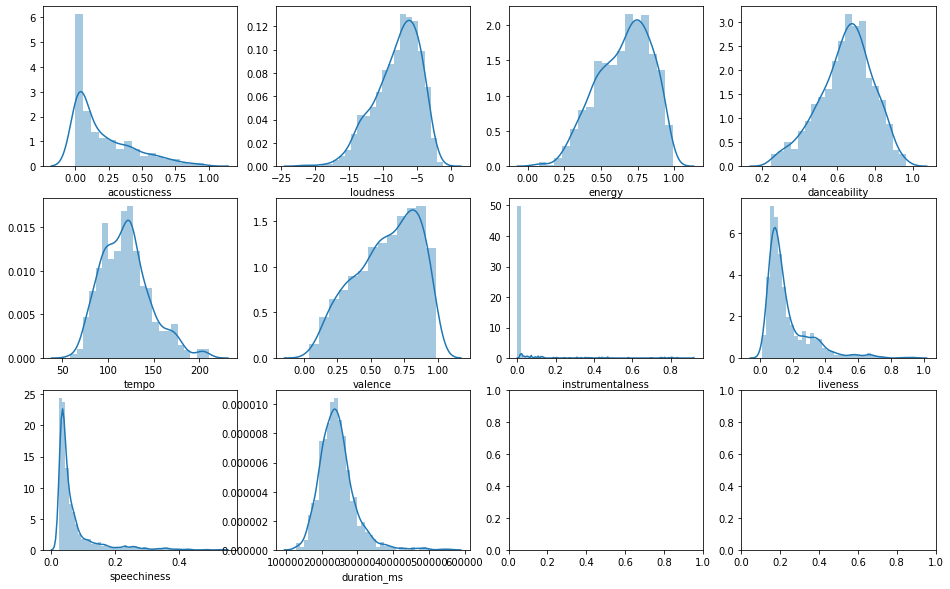

In [6]:
f, axs = plt.subplots(3, 4, figsize=(16, 10))
axs = np.ravel(axs)
for i, col in enumerate(cols):
    sns.distplot(df[col], ax=axs[i])

In [7]:
z_cols = [col + '_z' for col in cols]

In [8]:
df[z_cols] = df[cols].apply(zscore)

## Over time

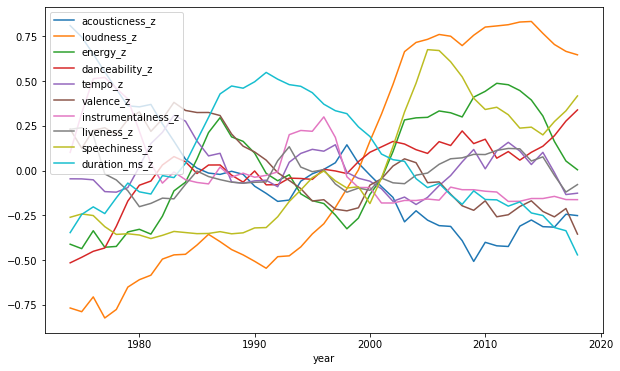

In [9]:
# Plot of five-year rolling averages of acoustic characteristics
df.groupby('year').mean().rolling(window=5).mean()[z_cols].plot(figsize=(10,6))

## Distance metrics

In [10]:
# Looks like there's a lot of variation in these columns, so let's use them
keys = ['acousticness_z', 'loudness_z', 'energy_z', 'danceability_z', 'valence_z']

In [11]:
def get_vector(a):
    return np.array([a[key] for key in keys])

In [12]:
def euclidean_distance(a, b):
    v1 = get_vector(a)
    v2 = get_vector(b)
    return np.linalg.norm(v1 - v2)

In [13]:
def cosine_similarity(a, b):
    v1 = get_vector(a)
    v2 = get_vector(b)
    return np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [14]:
# Average distance between two songs for each year, using both metrics
records = []
for year in range(1970, 2019):
    # List of song pairs for this year
    combinations = list(itertools.combinations(df[df.year == year].to_dict('records'), 2))
    records.append({
        'year': year,
        'euclidean_dist': np.mean([euclidean_distance(*c) for c in combinations]),
        'cosine_similarity': np.mean([cosine_similarity(*c) for c in combinations])
    })
years = pd.DataFrame.from_records(records)

In [15]:
# Most similar years, by cosine similarity
years.sort_values('cosine_similarity', ascending=False).head()

,cosine_similarity,euclidean_dist,year
41,0.405424,1.844460,2011
40,0.372814,2.184933,2010
44,0.299778,2.500612,2014
42,0.298534,2.284056,2012
36,0.296176,2.380890,2006


In [16]:
# Most similar years, by euclidean distance
years.sort_values('euclidean_dist').head()

,cosine_similarity,euclidean_dist,year
41,0.405424,1.844460,2011
46,0.247182,2.174291,2016
40,0.372814,2.184933,2010
13,0.180104,2.278544,1983
42,0.298534,2.284056,2012


In [17]:
# Most different years, by cosine similarity
years.sort_values('cosine_similarity').head()

,cosine_similarity,euclidean_dist,year
24,-0.041573,2.990288,1994
26,-0.025007,3.041607,1996
21,-0.017224,2.859156,1991
25,-0.004869,2.845128,1995
27,-0.003573,3.083378,1997


In [18]:
# Most different years, by euclidean distance
years.sort_values('euclidean_dist', ascending=False).head()

,cosine_similarity,euclidean_dist,year
4,0.170771,3.365366,1974
1,0.184165,3.325375,1971
7,0.185689,3.290159,1977
18,0.040924,3.159351,1988
12,0.044009,3.128241,1982


In [19]:
# Five-year rolling average
rolling = years.rolling(window=5).mean()

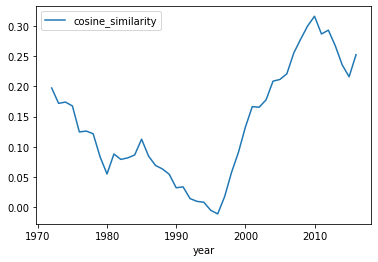

In [20]:
rolling.plot(x='year', y='cosine_similarity')

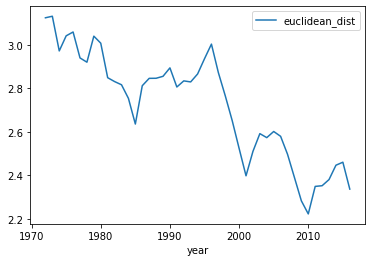

In [21]:
rolling.plot(x='year', y='euclidean_dist')